In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy


In [2]:
#Importación de Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf

In [3]:
# Normalizando Datos
# ------------------------------------
# Cargamos los datos de entrenamiento y prueba. Normalizamos las imágenes dividiendo por 255
# para llevar los valores de los píxeles al rango [0, 1].

x_train = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy")

In [4]:
# Split training data into train and validation sets
# ------------------------------------
# Dividimos el conjunto de entrenamiento en 90% entrenamiento y 10% validación para poder
# evaluar el desempeño del modelo durante el entrenamiento.

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_fine, 
    test_size=0.1, 
    stratify=y_train_fine
)    

In [5]:
#ANÁLISIS DE DATOS

# Distribución de Clases
print("Distribución de clases en y_train:")
unique_classes, class_counts = np.unique(y_train_fine, return_counts=True)
print(dict(zip(unique_classes, class_counts)))


Distribución de clases en y_train:
{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500, 20: 500, 21: 500, 22: 500, 23: 500, 24: 500, 25: 500, 26: 500, 27: 500, 28: 500, 29: 500, 30: 500, 31: 500, 32: 500, 33: 500, 34: 500, 35: 500, 36: 500, 37: 500, 38: 500, 39: 500, 40: 500, 41: 500, 42: 500, 43: 500, 44: 500, 45: 500, 46: 500, 47: 500, 48: 500, 49: 500, 50: 500, 51: 500, 52: 500, 53: 500, 54: 500, 55: 500, 56: 500, 57: 500, 58: 500, 59: 500, 60: 500, 61: 500, 62: 500, 63: 500, 64: 500, 65: 500, 66: 500, 67: 500, 68: 500, 69: 500, 70: 500, 71: 500, 72: 500, 73: 500, 74: 500, 75: 500, 76: 500, 77: 500, 78: 500, 79: 500, 80: 500, 81: 500, 82: 500, 83: 500, 84: 500, 85: 500, 86: 500, 87: 500, 88: 500, 89: 500, 90: 500, 91: 500, 92: 500, 93: 500, 94: 500, 95: 500, 96: 500, 97: 500, 98: 500, 99: 500}


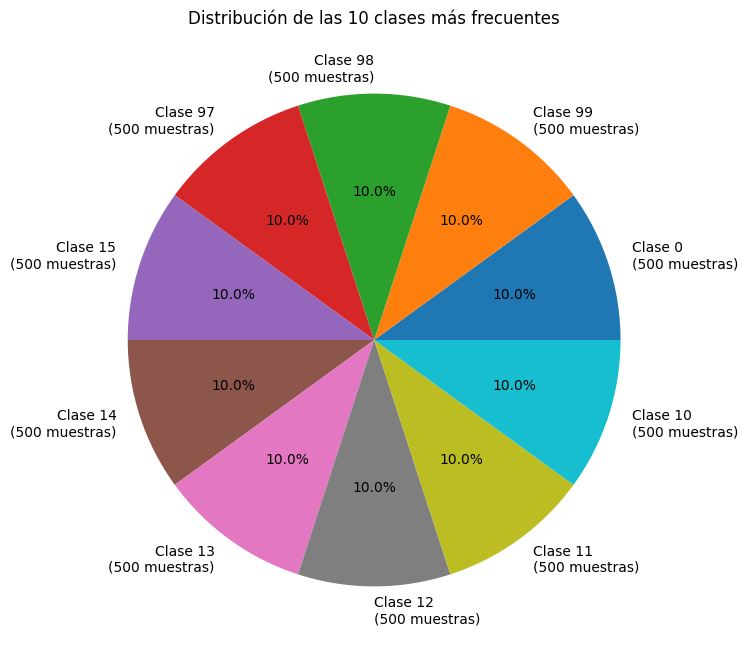

In [6]:
# 2. Gráfico circular para las N clases más frecuentes
plt.figure(figsize=(12, 8))
N = 10  # Mostrar las 100 (todas) clases más frecuentes
sorted_idx = np.argsort(class_counts)[::-1]
top_N_classes = unique_classes[sorted_idx][:N]
top_N_counts = class_counts[sorted_idx][:N]

plt.pie(top_N_counts, labels=[f'Clase {i}\n({count} muestras)' 
                             for i, count in zip(top_N_classes, top_N_counts)],
        autopct='%1.1f%%')
plt.title(f'Distribución de las {N} clases más frecuentes')
plt.show()
#Distribución es igual en todas las clases.

In [7]:
# Imprimir estadísticas numéricas
print("\nEstadísticas de la distribución de clases:")
print(f"Número total de clases: {len(unique_classes)}")
print(f"Promedio de muestras por clase: {np.mean(class_counts):.2f}")
print(f"Desviación estándar de muestras por clase: {np.std(class_counts):.2f}")
print(f"Mínimo de muestras en una clase: {np.min(class_counts)}")
print(f"Máximo de muestras en una clase: {np.max(class_counts)}")


Estadísticas de la distribución de clases:
Número total de clases: 100
Promedio de muestras por clase: 500.00
Desviación estándar de muestras por clase: 0.00
Mínimo de muestras en una clase: 500
Máximo de muestras en una clase: 500


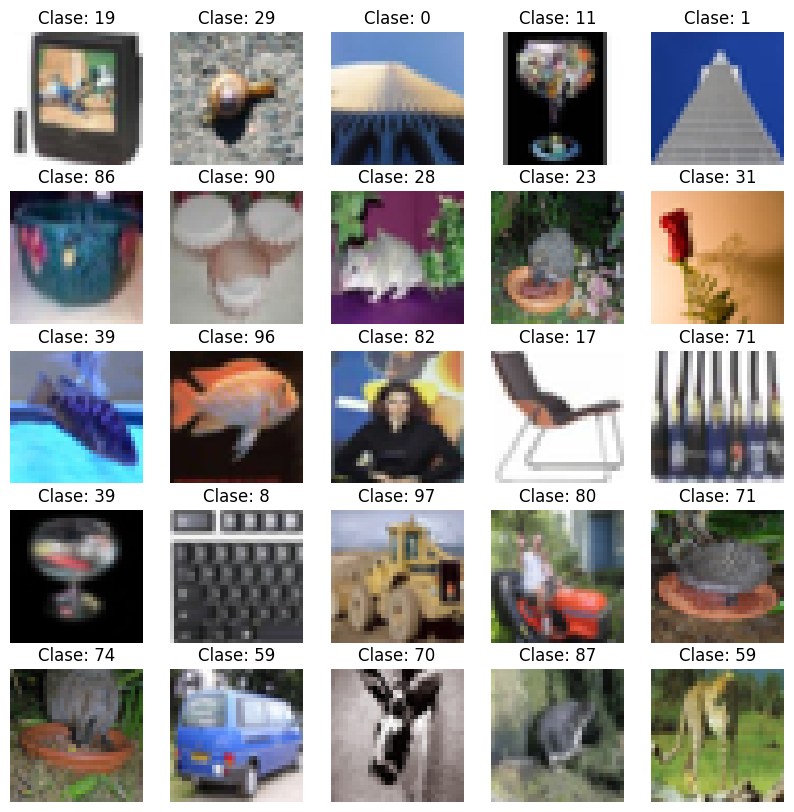

In [8]:
# Visualizar ejemplos de imágenes
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.set_title(f"Clase: {y_train_fine[i]}")
    ax.axis('off')
plt.show()


In [9]:
#DEFINICION DEL MODELO
# ------------------------------------
#Construimos una red neuronal multicapa (MLP) utilizando capas Dense para capturar relaciones no lineales.
# Batch Normalization y Dropout ayudan a mejorar la estabilidad y generalización del modelo.
    
def create_mlp_model(input_shape=(32, 32, 3), num_classes=100):
    model = Sequential([
        Flatten(input_shape=input_shape),
        
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    #Compilación del modelo con la pérdida de entropía cruzada para clasificación multiclase
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [10]:
#Entrenamiento del Modelo
# ------------------------------------
#Utilizamos un generador de imágenes (`ImageDataGenerator`) para aplicar técnicas de aumento de datos,
# como flip horizontal, rotación y desplazamiento, con el fin de mejorar la robustez del modelo.
# Los callbacks ayudan a reducir la tasa de aprendizaje y detener el entrenamiento temprano.

def train_model(x_train, y_train, x_val, y_val, batch_size=64, epochs=60):
    # Crear modelo
    model = create_mlp_model()
    
    # Configurar data augmentation solo para training
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Generador para training con augmentation
    train_generator = train_datagen.flow(
        x_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-6
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            "best_model.weights.h5",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            save_weights_only=True
        )
    ]
    
    # Entrenar el modelo - usar directamente los datos de validación sin generador
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=(x_val, y_val),  # Datos de validación sin augmentation
        callbacks=callbacks,
    )
    
    return model, history


In [11]:
# Generación del archivo de Submission
# ------------------------------------
# Las predicciones sobre el conjunto de prueba (`x_test`) se guardan en un archivo CSV en el formato
# especificado por la competencia, con columnas `Id` y `Label`.

def generate_submission(model, x_test, output_file="submission.csv"):
    # Predicciones manteniendo el orden original
    predictions = model.predict(x_test, batch_size=64).argmax(axis=1)
    
    # Crear DataFrame manteniendo el orden
    df = pd.DataFrame(predictions, columns=['Label'])
    df.index.name = 'Id'
    #df.to_csv(output_file, index=False)
    
    return df


In [12]:
# Visualización del Proceso de Entrenamiento
# ------------------------------------------
# Creamos gráficos para visualizar la precisión y la pérdida en el entrenamiento y validación,
# lo cual nos ayuda a observar si el modelo está mejorando o si existe sobreajuste.

def plot_training_history(history):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731012428.276472     104 service.cc:145] XLA service 0x5cbeb47018b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731012428.276540     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731012428.276545     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/704 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0235 - loss: 5.6588

I0000 00:00:1731012434.117333     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


700/704 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0530 - loss: 4.6071
Epoch 1: val_accuracy improved from -inf to 0.10460, saving model to best_model.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.0532 - loss: 4.6050 - val_accuracy: 0.1046 - val_loss: 3.9483 - learning_rate: 0.0010
Epoch 2/60
697/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1059 - loss: 3.9380
Epoch 2: val_accuracy improved from 0.10460 to 0.14240, saving model to best_model.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.1060 - loss: 3.9373 - val_accuracy: 0.1424 - val_loss: 3.7092 - learning_rate: 0.0010
Epoch 3/60
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1309 - loss: 3.7288
Epoch 3: val_accuracy improved from 0.14240 to 0.16340, saving model to best_model.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.1310 - loss: 3.7287 - val_accuracy: 0.1634 - val_loss: 3.5461 - learning_rate: 0.0010
Epoch 4/60
700/704 ━━━━━━━━━━━━━━━━━━━━ 0s

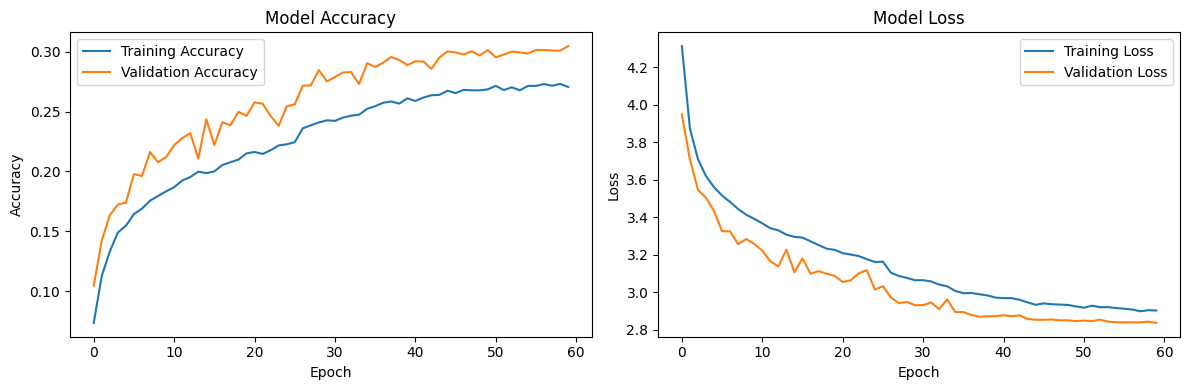

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [13]:
# Ejecución Principal
# -------------------
# En la ejecución principal, entrenamos el modelo, graficamos los resultados y generamos el archivo
# de submission.
if __name__ == "__main__":
    # Entrenamiento
    model, history = train_model(x_train, y_train, x_val, y_val)
    
    # Visualizar el entrenamiento
    plot_training_history(history)
    
    # Generar predicciones
    submission_df = generate_submission(model, x_test)
    

In [14]:
#Visualizar los datos del archivo Submission
submission_df

,Label
Id,
0,49
1,42
2,15
3,10
4,70
...,...
9995,41
9996,63
9997,51


In [15]:
#Generación de archivo .csv
submission_df.to_csv("submission.csv")